## Topic Modeling of Tweets Related to Istanbul Convention
### Berra Karayel 0054477

In [1]:
!pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-dvme9dy0
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-dvme9dy0
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4602 sha256=f6d07b153e2a3a37233811e17b3fa878a84b45b44fcc403e9ed4ea5b52e48293
  Stored in directory: /tmp/pip-ephem-wheel-cache-4261nidd/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [2]:
import numpy as np 
import pandas as pd

from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [3]:
from sklearn.model_selection import GridSearchCV

In [4]:
data = pd.read_csv('/content/Positive-Sentiment-Tweets.csv', encoding='utf-8')
data.head(10)

,Unnamed: 0,Unnamed: 0.1,Date,Tweet,Id,Sentiment
0,2,2900,2021-06-16 20:53:23+00:00,kadir şeker utanmak cezalandırıyorkenböyle hay...,1405267281052000000,positive
1,6,26695,2021-03-20 08:44:28+00:00,türki i̇stanbul sözleşme ayrılmak bakı tarih n...,1373193714538099968,positive
2,7,43171,2021-04-01 20:52:15+00:00,iftira mi mor halka kısa birörnek chp taciz te...,1377725518498400000,positive
3,8,20325,2021-03-20 10:40:13+00:00,gün geçmek kadın hak çoğalmak gerekmek kötü gi...,1373222840552600064,positive
4,9,27469,2021-03-20 08:28:44+00:00,i̇stanbulsözleşmesi istanbulsözleşmesiyasatır,1373189754364300032,positive
5,10,41396,2021-05-11 11:46:23+00:00,vazgeçmek i̇stanbul sözleşme yaşamak i̇stanbul...,1392083664540999936,positive
6,12,26126,2021-03-20 08:56:07+00:00,ben ölmek istemek yüz bugün yüksek ses istanbu...,1373196646637499904,positive
7,14,30246,2021-03-20 07:23:02+00:00,istanbulsözleşmesiuygulansinistanbulsözleşmesi...,1373173218396300032,positive
8,15,4824,2021-03-28 07:38:09+00:00,ındanlarndsyorki i̇stanbul sözleşme var desen ...,1376076124690700032,positive
9,16,21051,2021-03-20 10:24:47+00:00,gerçek yazık hal gelmek istanbulsöezleşmesi is...,1373218958099300096,positive


In [5]:
data.shape

(1689, 6)

In [6]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [7]:
data['Tweet'] = data.Tweet.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

In [8]:
tokens_tweets = list(sent_to_words(data['Tweet']))

GSDMM

Hyper-parameters of the GSDMM model:

- K = 6. It is the number of clusters. We set this value after several experiments in which we started from 15 clusters. As we increased the number of clusters, the empty clusters started to appear. This was why we settled with 6 clusters. 

Hyperparameters; (These default parameters would work for many short texts.)

- alpha =0.01 1 and beta = 0.01. 

- n_iters = 30.  Number of iteration.

In [9]:
np.random.seed(0) #for reproducability

In [10]:
tokens_tweets = list(sent_to_words(data["Tweet"]))

In [11]:
mgp = MovieGroupProcess(K=15, alpha=0.01, beta=0.01, n_iters=30) 

vocab = set(x for tweet in tokens_tweets for x in tweet)
n_terms = len(vocab)
model = mgp.fit(tokens_tweets, n_terms)

In stage 0: transferred 1380 clusters with 15 clusters populated
In stage 1: transferred 794 clusters with 15 clusters populated
In stage 2: transferred 616 clusters with 15 clusters populated
In stage 3: transferred 515 clusters with 15 clusters populated
In stage 4: transferred 511 clusters with 15 clusters populated
In stage 5: transferred 492 clusters with 15 clusters populated
In stage 6: transferred 453 clusters with 15 clusters populated
In stage 7: transferred 432 clusters with 15 clusters populated
In stage 8: transferred 447 clusters with 15 clusters populated
In stage 9: transferred 398 clusters with 15 clusters populated
In stage 10: transferred 383 clusters with 15 clusters populated
In stage 11: transferred 379 clusters with 15 clusters populated
In stage 12: transferred 352 clusters with 15 clusters populated
In stage 13: transferred 338 clusters with 15 clusters populated
In stage 14: transferred 370 clusters with 15 clusters populated
In stage 15: transferred 359 clust

In [12]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [13]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 20)

Number of documents per topic : [ 61  26 868  20  27  30 279  53  20  24  94  76  31  19  61]

Most important clusters (by number of docs inside): [ 2  6 10 11 14  0  7 12  5  4  1  9  8  3 13]

Cluster 2 : [('sözleşme', 405), ('kadın', 392), ('bir', 343), ('stanbul', 306), ('olmak', 204), ('ülke', 121), ('demek', 116), ('şiddet', 111), ('yaşamak', 106), ('hak', 98), ('bu', 86), ('var', 83), ('ölmek', 82), ('ben', 82), ('yok', 79), ('mi', 76), ('desen', 72), ('değmek', 70), ('etmek', 70), ('kadar', 69)]

Cluster 6 : [('bir', 121), ('sözleşme', 119), ('kadın', 108), ('stanbul', 106), ('olmak', 54), ('demek', 48), ('yaşamak', 36), ('ülke', 34), ('desen', 34), ('hak', 33), ('mi', 32), ('var', 29), ('ben', 26), ('ölmek', 24), ('yok', 23), ('etmek', 22), ('bu', 22), ('iptal', 22), ('gün', 21), ('insan', 21)]

Cluster 10 : [('the', 63), ('iş', 59), ('to', 58), ('women', 53), ('turkey', 48), ('in', 41), ('for', 32), ('not', 31), ('of', 30), ('this', 27), ('and', 25), ('safe', 20), ('us', 17),

In [14]:
gsdmm_clusters = [

["Cluster 10 : [('sözleşme', 80), ('stanbul', 58), ('bir', 33), ('olmak', 33), ('kadın', 29), ('hal', 12), ('demek', 12), ('biz', 11), ('desen', 11), ('var', 10), ('vermek', 10), ('iyi', 9), ('slâm', 9), ('kalmak', 9), ('avrupa', 8), ('devlet', 8), ('mi', 8), ('iş', 8), ('yok', 8), ('cinayet', 8)"],

["Cluster 11 : [('sözleşme', 61), ('kadın', 59), ('stanbul', 52), ('bir', 24), ('olmak', 24), ('var', 20), ('korumak', 19), ('tecavüz', 14), ('mi', 14), ('bu', 13), ('şiddet', 13), ('ülke', 12), ('demek', 12), ('cinayet', 11), ('taciz', 11), ('yok', 9), ('değmek', 9), ('desen', 9), ('kadar', 9), ('hak', 8)"],

["Cluster 6 : [('sözleşme', 31), ('stanbul', 26), ('kadın', 16), ('chp', 16), ('bir', 10), ('tecavüz', 10), ('taciz', 8), ('iç', 7), ('korumak', 6), ('made', 6), ('nin', 6), ('olmak', 5), ('demek', 5), ('desen', 5), ('mi', 4), ('çıkarmak', 4), ('sıra', 4), ('etmek', 4), ('önem', 4), ('gelmek', 4)"],

["Cluster 3 : [('sözleşme', 39), ('stanbul', 32), ('kadın', 17), ('ölmek', 14), ('değmek', 13), ('olmak', 13), ('yaşamak', 12), ('slâm', 10), ('bir', 9), ('zaten', 8), ('var', 7), ('istemek', 7), ('insan', 7), ('bu', 6), ('iş', 6), ('ada', 6), ('mu', 6), ('desen', 6), ('allah', 5), ('cinayet', 5)"],

["Cluster 5 : [('sözleşme', 27), ('stanbul', 23), ('kadın', 21), ('bir', 11), ('cinayet', 11), ('yaşamak', 10), ('demek', 8), ('kalmak', 7), ('yıl', 7), ('almak', 6), ('artmak', 6), ('katmak', 6), ('sonra', 6), ('şükür', 6), ('olmak', 5), ('iş', 5), ('imza', 5), ('şiddet', 5), ('etmek', 4), ('iptal', 4)"],

["Cluster 13 : [('sözleşme', 19), ('stanbul', 13), ('olmak', 11), ('bir', 10), ('aile', 10), ('yapı', 8), ('çöp', 7), ('fatih', 7), ('ahlak', 7), ('millet', 6), ('var', 6), ('erbakan', 6), ('türk', 6), ('artık', 6), ('şükür', 6), ('önce', 5), ('lider', 5), ('atmak', 4), ('ayasofya', 4), ('şimdi', 4)"],

["Cluster 1 : [('sözleşme', 41), ('kadın', 29), ('stanbul', 27), ('bir', 20), ('yaşamak', 18), ('mi', 12), ('demek', 11), ('insan', 10), ('ölmek', 9), ('var', 9), ('yok', 7), ('atmak', 6), ('slâm', 6), ('se', 5), ('böyle', 5), ('bu', 5), ('şiddet', 5), ('ben', 5), ('size', 5), ('allah', 5)"],

["Cluster 9 : [('bir', 16), ('sözleşme', 12), ('aile', 11), ('olmak', 10), ('stanbul', 8), ('erkek', 8), ('elhamdülillah', 8), ('kadın', 5), ('ede', 5), ('müslüman', 5), ('feshetmek', 5), ('nesil', 4), ('ifade', 4), ('bitmek', 4), ('ge', 4), ('kadar', 3), ('yıkanmak', 3), ('söz', 3), ('türk', 3), ('belâ', 3)"],

["Cluster 8 : [('sözleşme', 24), ('bir', 21), ('stanbul', 13), ('toplum', 13), ('yapı', 8), ('bu', 7), ('olmak', 6), ('lgbt', 6), ('aile', 6), ('kadın', 6), ('değmek', 6), ('yi', 5), ('kendi', 5), ('var', 5), ('ad', 5), ('yaşamak', 4), ('güzel', 4), ('allah', 4), ('alt', 4), ('cinsiyet', 4)"],

["Cluster 14 : [('sözleşme', 18), ('kadın', 13), ('stanbul', 10), ('mi', 7), ('alt', 6), ('sağlamak', 5), ('korumak', 5), ('kanu', 4), ('bir', 4), ('teşekkür', 4), ('fesih', 4), ('sapkın', 4), ('koru', 4), ('hak', 3), ('taraf', 3), ('yanlış', 3), ('düzenlemek', 3), ('eder', 3), ('hoca', 3), ('imek', 3)"],

["Cluster 4 : [('sözleşme', 25), ('stanbul', 24), ('kadın', 9), ('bir', 8), ('iptal', 7), ('imza', 6), ('çocuk', 6), ('desen', 5), ('değişmek', 5), ('yanlış', 5), ('kalmak', 5), ('vermek', 4), ('olmak', 4), ('etmek', 4), ('ölmek', 4), ('kanu', 4), ('korumak', 4), ('türk', 3), ('hal', 3), ('iyi', 3)"],

["Cluster 12 : [('sözleşme', 27), ('stanbul', 19), ('bir', 12), ('yok', 9), ('olmak', 9), ('kendi', 8), ('kadın', 7), ('ülke', 7), ('kabul', 7), ('şey', 6), ('desen', 6), ('etmek', 6), ('istemek', 5), ('allah', 5), ('mi', 5), ('bu', 4), ('uygu', 4), ('ben', 4), ('yapmak', 4), ('se', 4)"],

["Cluster 0 : [('sözleşme', 15), ('stanbul', 11), ('kadın', 9), ('bir', 9), ('demek', 7), ('size', 6), ('allah', 6), ('madde', 5), ('aile', 4), ('se', 4), ('deva', 4), ('çocuk', 4), ('var', 4), ('durmak', 4), ('etmek', 3), ('uygulamak', 3), ('ne', 3), ('gerekmek', 3), ('ileri', 3), ('millet', 3)"],

["Cluster 7 : [('kadın', 9), ('sözleşme', 8), ('stanbul', 6), ('şiddet', 5), ('iptal', 5), ('cinayet', 4), ('ooohhh', 4), ('gün', 3), ('millet', 3), ('olmak', 3), ('imzalamak', 3), ('siz', 3), ('dayamak', 3), ('eşcinsel', 3), ('gi', 3), ('ni', 3), ('eşit', 3), ('bu', 2), ('ediyor', 2), ('ülke', 2)"],

["Cluster 2 : [('sözleşme', 13), ('stanbul', 11), ('olmak', 8), ('bir', 7), ('parti', 6), ('kadın', 5), ('taraf', 5), ('demek', 4), ('bu', 4), ('var', 4), ('değmek', 4), ('lgbt', 4), ('ak', 4), ('konuşmak', 3), ('ayrıç', 3), ('sosyal', 3), ('erkek', 3), ('tam', 3), ('adalet', 3), ('iş', 2)"]]



In [15]:
gsdmm_clusters = pd.DataFrame.from_dict(gsdmm_clusters)

In [16]:
gsdmm_clusters

,0
0,"Cluster 10 : [('sözleşme', 80), ('stanbul', 58..."
1,"Cluster 11 : [('sözleşme', 61), ('kadın', 59),..."
2,"Cluster 6 : [('sözleşme', 31), ('stanbul', 26)..."
3,"Cluster 3 : [('sözleşme', 39), ('stanbul', 32)..."
4,"Cluster 5 : [('sözleşme', 27), ('stanbul', 23)..."
5,"Cluster 13 : [('sözleşme', 19), ('stanbul', 13..."
6,"Cluster 1 : [('sözleşme', 41), ('kadın', 29), ..."
7,"Cluster 9 : [('bir', 16), ('sözleşme', 12), ('..."
8,"Cluster 8 : [('sözleşme', 24), ('bir', 21), ('..."
9,"Cluster 14 : [('sözleşme', 18), ('kadın', 13),..."


In [17]:
gsdmm_clusters.columns

RangeIndex(start=0, stop=1, step=1)

In [18]:
gsdmm_clusters.rename(columns={0: "Dominant Keywords for GSDMM Clusters"}, inplace=True)

In [19]:
type(gsdmm_clusters)

pandas.core.frame.DataFrame

In [20]:
gsdmm_clusters.columns

Index(['Dominant Keywords for GSDMM Clusters'], dtype='object')

In [21]:
gsdmm_clusters[['Cluster No.(Importance)','Dominant Keywords:GSDMM']] = gsdmm_clusters["Dominant Keywords for GSDMM Clusters"].str.split(":",expand=True,)
gsdmm_clusters

,Dominant Keywords for GSDMM Clusters,Cluster No.(Importance),Dominant Keywords:GSDMM
0,"Cluster 10 : [('sözleşme', 80), ('stanbul', 58...",Cluster 10,"[('sözleşme', 80), ('stanbul', 58), ('bir', 3..."
1,"Cluster 11 : [('sözleşme', 61), ('kadın', 59),...",Cluster 11,"[('sözleşme', 61), ('kadın', 59), ('stanbul',..."
2,"Cluster 6 : [('sözleşme', 31), ('stanbul', 26)...",Cluster 6,"[('sözleşme', 31), ('stanbul', 26), ('kadın',..."
3,"Cluster 3 : [('sözleşme', 39), ('stanbul', 32)...",Cluster 3,"[('sözleşme', 39), ('stanbul', 32), ('kadın',..."
4,"Cluster 5 : [('sözleşme', 27), ('stanbul', 23)...",Cluster 5,"[('sözleşme', 27), ('stanbul', 23), ('kadın',..."
5,"Cluster 13 : [('sözleşme', 19), ('stanbul', 13...",Cluster 13,"[('sözleşme', 19), ('stanbul', 13), ('olmak',..."
6,"Cluster 1 : [('sözleşme', 41), ('kadın', 29), ...",Cluster 1,"[('sözleşme', 41), ('kadın', 29), ('stanbul',..."
7,"Cluster 9 : [('bir', 16), ('sözleşme', 12), ('...",Cluster 9,"[('bir', 16), ('sözleşme', 12), ('aile', 11),..."
8,"Cluster 8 : [('sözleşme', 24), ('bir', 21), ('...",Cluster 8,"[('sözleşme', 24), ('bir', 21), ('stanbul', 1..."
9,"Cluster 14 : [('sözleşme', 18), ('kadın', 13),...",Cluster 14,"[('sözleşme', 18), ('kadın', 13), ('stanbul',..."


In [22]:
# I didn`t rename the clusters

topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
               'type 7',
               'type 8',
               'type 9',
               'type 10',
               'type 11',
               'type 12',
               'type 13',
               'type 14',
               'type 15'
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [23]:
def create_topics_dataframe(data_text=data.Tweet,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=tokens_tweets):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        #result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(tokens_tweets[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [24]:
result = create_topics_dataframe(data_text=data.Tweet, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=tokens_tweets)
result.head(5)

,Text,Topic,Rating,Lemma-text
0,kadir şeker utanmak cezalandırıyorkenböyle hay...,type 1,NaN,"[kadir, şeker, utanmak, pis, ev, hapis, ad, al..."
1,türki i̇stanbul sözleşme ayrılmak bakı tarih n...,type 1,NaN,"[türki, stanbul, sözleşme, ayrılmak, bakı, tar..."
2,iftira mi mor halka kısa birörnek chp taciz te...,type 1,NaN,"[iftira, mi, mor, halka, kısa, birörnek, chp, ..."
3,gün geçmek kadın hak çoğalmak gerekmek kötü gi...,type 7,NaN,"[gün, geçmek, kadın, hak, çoğalmak, gerekmek, ..."
4,i̇stanbulsözleşmesi istanbulsözleşmesiyasatır,type 1,NaN,[]


# Visualization for the GSDM model


In [25]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title="Figure 4. GSDMM for Tweets with Positive Sentiment", color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [ ]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

## WordClouds

In [ ]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [ ]:
result = result.drop('Lemma-text', axis=1)

In [ ]:
from wordcloud import WordCloud 

In [ ]:
my_stopwords = ["istanbul", "stanbul", "sözleşme", "böyle", "bir", "bu", "şey", "mi", "mı", "var", "tamam"]

In [ ]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15, stopwords = my_stopwords
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

In [ ]:
my_stopwords = ["istanbul", "stanbul", "sözleşme", "böyle", "bir", "bu", "şey", "mi", "mı", "var", "tamam"]

In [ ]:
?WordCloud

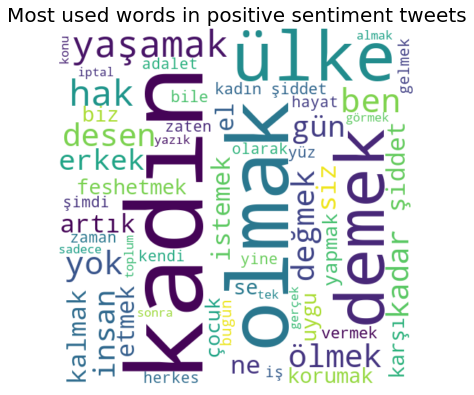

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in positive sentiment tweets")

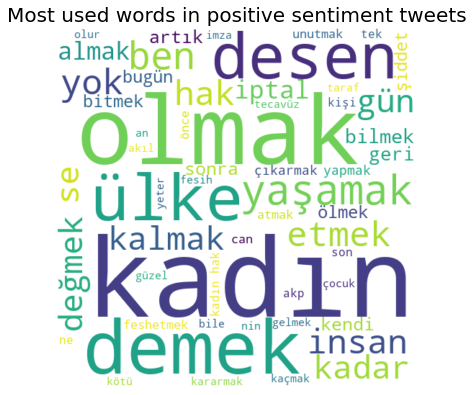

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in positive sentiment tweets")

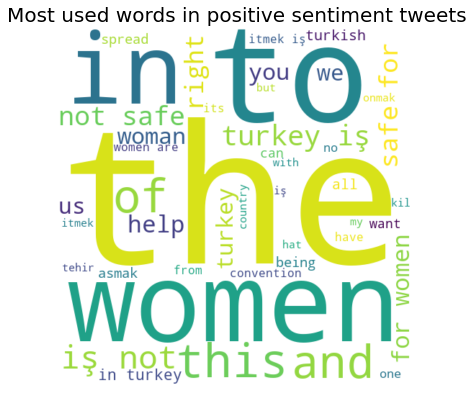

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in positive sentiment tweets")

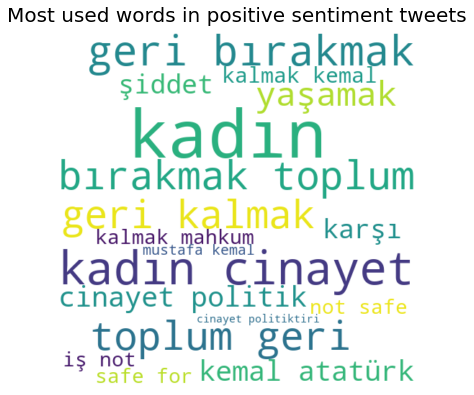

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in positive sentiment tweets")

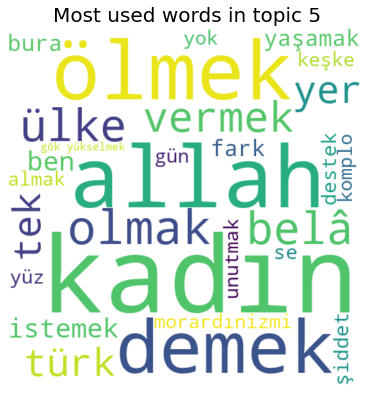

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

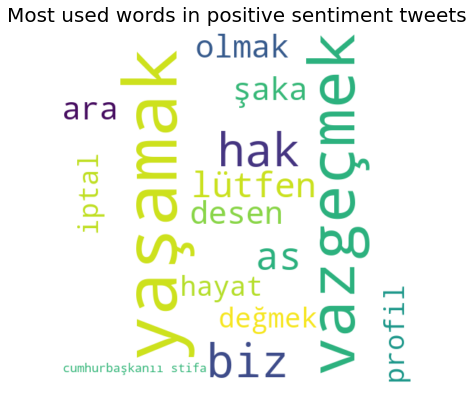

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in positive sentiment tweets")

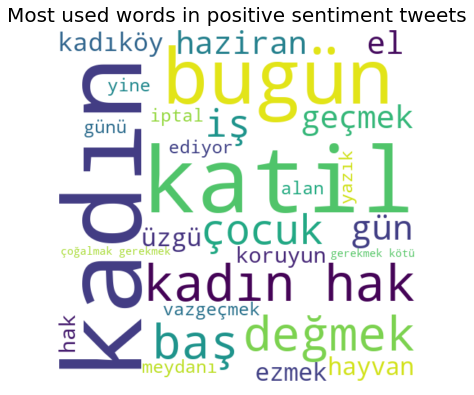

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 7'], title="Most used words in positive sentiment tweets")

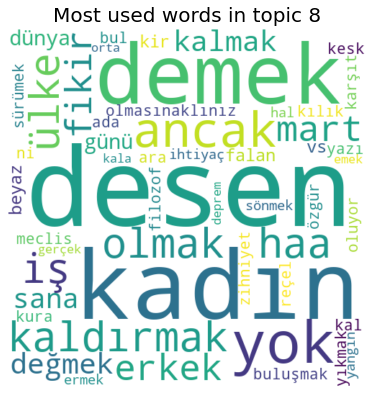

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 8'], title="Most used words in topic 8")

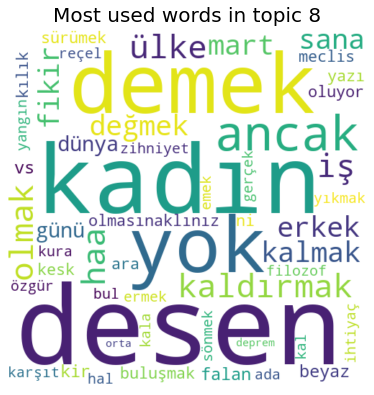

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 8'], title="Most used words in topic 8")

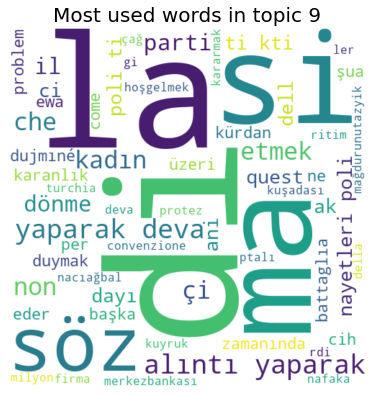

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 9'], title="Most used words in topic 9")

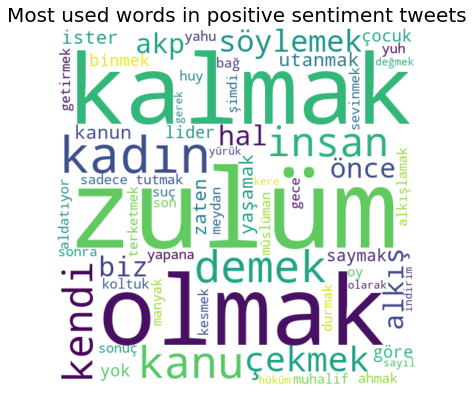

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 10'], title="Most used words in positive sentiment tweets")

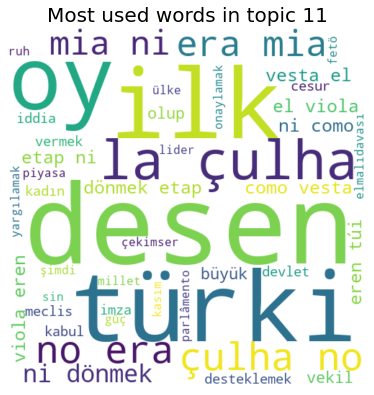

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 11'], title="Most used words in topic 11")

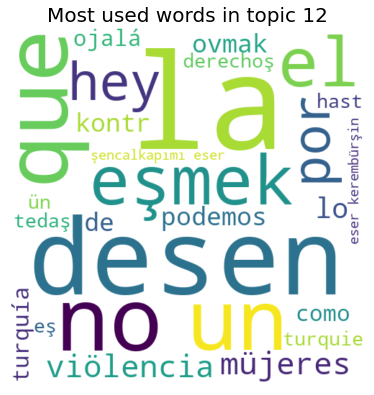

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 12'], title="Most used words in topic 12")

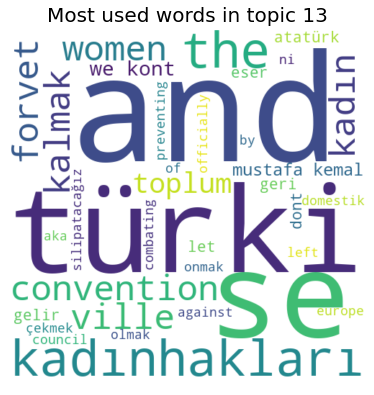

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 13'], title="Most used words in topic 13")

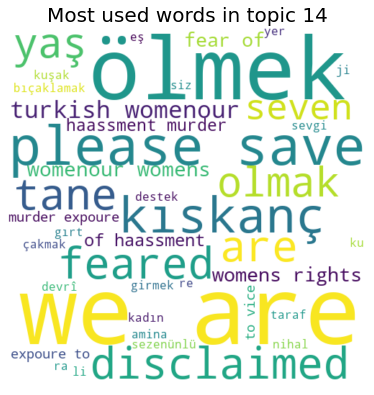

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 14'], title="Most used words in topic 14")

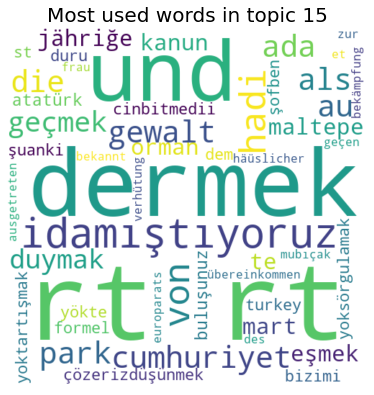

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 15'], title="Most used words in topic 15")